## 1.数据整理

### 载入数据

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [56]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [57]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  
train.info()
test.info()
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ 

### 整理数据

In [58]:
#首先整理test数据
#展现Open为nan的数据
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())
test['Date']=pd.to_datetime(test['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)

# print(test["StateHoliday"].value_counts())

test.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [59]:
#接着整理store数据

#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

print(store.query('CompetitionDistance=="NaN"'))
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
def f(x):
    return x-int(x)
print(store['CompetitionDistance'].apply(f).value_counts())
# 由于CompetitionDistance所有的小数部分都是0把CompetitionDistance转为int
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))
# 1115-354=761
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceYear']=0
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceMonth']=0

print(min(train['Date']))
print(min(test['Year']))
#训练值里最小的日期是2013-01-01，把没有开业时间的竞争对手店面开店时间随机设置到训练时间之前的随机年份和月份并且改为int型
random.seed(10)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

print(store['Promo2'].value_counts())
#571说明没有参与促销的商店是571
print(store['Promo2SinceWeek'].value_counts())
print(store['Promo2SinceYear'].value_counts())
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

store.info()


     Store  StoreType  Assortment  CompetitionDistance  \
290    291          4           1                  nan   
621    622          1           3                  nan   
878    879          4           1                  nan   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        nan                       nan       0   
621                        nan                       nan       0   
878                        nan                       nan       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              nan              nan              NaN  
621              nan              nan              NaN  
878            5.000         2013.000  Feb,May,Aug,Nov  
0.000    1115
Name: CompetitionDistance, dtype: int64
354
2013-01-01
2015
1    571
0    544
Name: Promo2, dtype: int64
14.000    81
40.000    77
31.000    44
10.000    42
5.000     39
37.000    35
1.000     35
45.000    34
13.000    34
22.000    33
18.000    29
35.0

In [60]:
#处理PromoInterval
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'1,4,7,10','Feb,May,Aug,Nov':'2,5,8,11','Mar,Jun,Sept,Dec':'3,6,9,12'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270,9,2008,0,0,0,"0,0,0,0"
1,2,1,1,570,11,2007,1,13,2010,"1,4,7,10"
2,3,1,1,14130,12,2006,1,14,2011,"1,4,7,10"
3,4,3,3,620,9,2009,0,0,0,"0,0,0,0"
4,5,1,1,29910,4,2015,0,0,0,"0,0,0,0"


In [61]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1)
store['PromoInterval2']=pd.Series(PromoInterval2)
store['PromoInterval3']=pd.Series(PromoInterval3)
store['PromoInterval4']=pd.Series(PromoInterval4)
        
store.info()            
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 14 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null int32
Assortment                   1115 non-null int32
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
PromoInterval1               1115 non-null object
PromoInterval2               1115 non-null object
PromoInterval3               1115 non-null object
PromoInterval4               1115 non-null object
dtypes: int32(7), int64(2), object(5)
memory usage: 91.5+ KB


In [62]:
# 将PromoInterval1，PromoInterval2，PromoInterval3，PromoInterval4列转为一个特征PromoIntervalMonth的不同值
store=store.melt(
id_vars=['Store','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],   #要保留的主字段
var_name='PromoIntervalTemp',                     #拉长的分类变量
value_name="PromoIntervalMonth"         #拉长的度量值名称
)
print(store.info())
print(store.head())
print(store['PromoIntervalTemp'].value_counts())
store.drop('PromoIntervalTemp',axis=1, inplace=True)
store.drop('PromoInterval',axis=1, inplace=True)
store = store.drop_duplicates()
store['PromoIntervalMonth']=store['PromoIntervalMonth'].astype(int)
print(store.info())
print(store.head())
print(store['PromoIntervalMonth'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 12 columns):
Store                        4460 non-null int64
StoreType                    4460 non-null int32
Assortment                   4460 non-null int32
CompetitionDistance          4460 non-null int32
CompetitionOpenSinceMonth    4460 non-null int32
CompetitionOpenSinceYear     4460 non-null int32
Promo2                       4460 non-null int64
Promo2SinceWeek              4460 non-null int32
Promo2SinceYear              4460 non-null int32
PromoInterval                4460 non-null object
PromoIntervalTemp            4460 non-null object
PromoIntervalMonth           4460 non-null object
dtypes: int32(7), int64(2), object(3)
memory usage: 296.2+ KB
None
   Store  StoreType  Assortment  CompetitionDistance  \
0      1          3           1                 1270   
1      2          1           1                  570   
2      3          1           1                14130   
3      4   

In [63]:
#整理train数据
# print(train.info())
train['Date']=pd.to_datetime(train['Date'])

# 把date拆成year，month和day，重新设置DayOfWeek

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)


print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null int32
SchoolHoliday    1017209 non-null int64
Year             1017209 non-null int64
Month            1017209 non-null int64
Day              1017209 non-null int64
WeekOfYear       1017209 non-null int64
dtypes: int32(1), int64(11)
memory usage: 89.2 MB
None


### 合并数据

In [64]:
# 将train数据和store数据合并
train_store=pd.merge(train,store,how='inner',left_on=['Store'],right_on=['Store'])

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 21 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
dtypes: int32(9), int64(12)
memory usage: 339.8 MB


In [65]:
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==0')[['Store','Year','Month','Day']].drop_duplicates()))
#给参加促销活动的数据去重
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']]))
print(len(train_store.query('Promo2==1')[['Store','Year','Month','Day']].drop_duplicates()))

train_store=train_store.drop_duplicates()
print(len(train_store))

train_store['Promoing']=0

508031
508031
2036712
509178
2544743


In [66]:
#总数1017209
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
train_store.loc[(train_store['Promo2']==1)&(train_store['PromoIntervalMonth']==train_store['Month'])&(((train_store['Promo2SinceYear']==train_store['Year'])&(train_store['Promo2SinceWeek']<=train_store['WeekOfYear']))|train_store['Promo2SinceYear']<train_store['Year']),'Promoing']=1
train_store['Promoing'].value_counts()

0    2369951
1     174792
Name: Promoing, dtype: int64

In [67]:
#去掉不必要的或者重复的特征
train_store.info()
train_store.drop('PromoIntervalMonth',axis=1, inplace=True)

train_store.drop('Promo2SinceWeek',axis=1, inplace=True)

train_store.drop('Promo2SinceYear',axis=1, inplace=True)

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries, 0 to 2544742
Data columns (total 22 columns):
Store                        int64
DayOfWeek                    int64
Sales                        int64
Customers                    int64
Open                         int64
Promo                        int64
StateHoliday                 int32
SchoolHoliday                int64
Year                         int64
Month                        int64
Day                          int64
WeekOfYear                   int64
StoreType                    int32
Assortment                   int32
CompetitionDistance          int32
CompetitionOpenSinceMonth    int32
CompetitionOpenSinceYear     int32
Promo2                       int64
Promo2SinceWeek              int32
Promo2SinceYear              int32
PromoIntervalMonth           int32
Promoing                     int64
dtypes: int32(9), int64(13)
memory usage: 359.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544743 entries,

In [68]:
#整理的目标总数为1017209
train_store=train_store.drop_duplicates()
print(len(train_store))

1192001


In [69]:
# 整理Promoing特征并去重
temp_train_store=train_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
train_store=train_store.drop('Promoing',axis=1).drop_duplicates()
train_store=pd.merge(train_store,temp_train_store,how='left',on=['Store','Year','Month','Day'])
train_store['Promoing']=train_store['Promoing'].fillna(0)
train_store['Promoing']=train_store['Promoing'].astype(int)
print(train_store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int32
SchoolHoliday                1017209 non-null int64
Year                         1017209 non-null int64
Month                        1017209 non-null int64
Day                          1017209 non-null int64
WeekOfYear                   1017209 non-null int64
StoreType                    1017209 non-null int32
Assortment                   1017209 non-null int32
CompetitionDistance          1017209 non-null int32
CompetitionOpenSinceMonth    1017209 non-null int32
CompetitionOpenSinceYear     1017209 non-null int32
Pro

In [70]:
#添加是否有竞争对手信息，然后删除竞争对手开始时间年/月
train_store['IsCompetition']=0
train_store.head()
train_store.loc[(train_store['CompetitionDistance']!=0)&((train_store['CompetitionOpenSinceYear']<train_store['Year'])|(train_store['CompetitionOpenSinceYear']==train_store['Year']&(train_store['CompetitionOpenSinceMonth']<=train_store['Month']))),'IsCompetition']=1
train_store['IsCompetition'].value_counts()
train_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB


In [71]:
# 合并test
test_store=pd.merge(test,store,how='inner',left_on=['Store'],right_on=['Store'])
print(test.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 20 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
Sch

In [72]:
test_store=test_store.drop_duplicates()
print(len(test_store))
test_store['Promoing']=0
#开始清洗
#标记出正在参与Promo的记录
# train_store.query('Promo2==1 & PromoIntervalMonth==Month & ((Promo2SinceYear==Year & Promo2SinceWeek<=WeekOfYear) | (Promo2SinceYear<Year))')['Promoing']=1
test_store.loc[(test_store['Promo2']==1)&(test_store['PromoIntervalMonth']==test_store['Month'])&(((test_store['Promo2SinceYear']==test_store['Year'])&(test_store['Promo2SinceWeek']<=test_store['WeekOfYear']))|test_store['Promo2SinceYear']<test_store['Year']),'Promoing']=1
test_store['Promoing'].value_counts()

test_store.drop(['PromoIntervalMonth','Promo2SinceWeek','Promo2SinceYear'],axis=1, inplace=True)

test_store.info()

112656
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112656 entries, 0 to 112655
Data columns (total 18 columns):
Id                           112656 non-null int64
Store                        112656 non-null int64
DayOfWeek                    112656 non-null int64
Open                         112656 non-null int32
Promo                        112656 non-null int64
StateHoliday                 112656 non-null int32
SchoolHoliday                112656 non-null int64
Year                         112656 non-null int64
Month                        112656 non-null int64
Day                          112656 non-null int64
WeekOfYear                   112656 non-null int64
StoreType                    112656 non-null int32
Assortment                   112656 non-null int32
CompetitionDistance          112656 non-null int32
CompetitionOpenSinceMonth    112656 non-null int32
CompetitionOpenSinceYear     112656 non-null int32
Promo2                       112656 non-null int64
Promoing       

In [73]:
test_store=test_store.drop_duplicates()
print(len(test_store))
#目标是整理出41088条记录

46324


In [74]:
# 依据Promoing特征来去重
temp_test_store=test_store.query('Promoing==1')[['Store','Year','Month','Day','Promoing']]
test_store=test_store.drop('Promoing',axis=1).drop_duplicates()
test_store=pd.merge(test_store,temp_test_store,how='left',on=['Store','Year','Month','Day'])
test_store['Promoing']=test_store['Promoing'].fillna(0)
print(len(test_store))

41088


In [75]:
#添加是否有竞争对手信息特征IsCompetition，然后删除竞争对手开始时间年/月
test_store['IsCompetition']=0
test_store.head()
test_store.loc[(test_store['CompetitionDistance']!=0)&((test_store['CompetitionOpenSinceYear']<test_store['Year'])|(test_store['CompetitionOpenSinceYear']==test_store['Year']&(test_store['CompetitionOpenSinceMonth']<=test_store['Month']))),'IsCompetition']=1
test_store.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
test_store['Promoing']=test_store['Promoing'].astype(int)
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB


In [76]:
# 整理完成以后的train_store和test_store
test_store.info()
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                     41088 non-null int64
Store                  41088 non-null int64
DayOfWeek              41088 non-null int64
Open                   41088 non-null int32
Promo                  41088 non-null int64
StateHoliday           41088 non-null int32
SchoolHoliday          41088 non-null int64
Year                   41088 non-null int64
Month                  41088 non-null int64
Day                    41088 non-null int64
WeekOfYear             41088 non-null int64
StoreType              41088 non-null int32
Assortment             41088 non-null int32
CompetitionDistance    41088 non-null int32
Promo2                 41088 non-null int64
Promoing               41088 non-null int32
IsCompetition          41088 non-null int64
dtypes: int32(6), int64(11)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (

In [77]:
train_store.isnull().any().any()
test_store.isnull().any().any()

False

## 数据探索

In [78]:
# 查看train_store和test_store
print(train_store.info())
print(test_store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                  1017209 non-null int64
DayOfWeek              1017209 non-null int64
Sales                  1017209 non-null int64
Customers              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(13)
memory usage: 128.1 MB
None
<cl

In [79]:
#test里不存在customers，所以将train里的customers去掉，test里的id无用所以去掉，store对于预测来说无用去掉，sales属于结果放在train_target里
train_data=train_store.drop(['Store','Customers','Sales'],axis=1)
test_data=test_store.drop(['Id','Store'],axis=1)
train_target=train_store['Sales']

In [80]:
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.2, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))


In [81]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [83]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

In [84]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:5.58565	eval-rmse:5.58687	train-rmspe:0.908763	eval-rmspe:0.909092
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:3.91978	eval-rmse:3.92073	train-rmspe:0.896691	eval-rmspe:0.897024
[2]	train-rmse:2.75734	eval-rmse:2.75822	train-rmspe:0.860373	eval-rmspe:0.860695
[3]	train-rmse:1.94735	eval-rmse:1.94788	train-rmspe:0.789526	eval-rmspe:0.789702
[4]	train-rmse:1.39196	eval-rmse:1.39281	train-rmspe:0.689804	eval-rmspe:0.689428
[5]	train-rmse:1.00431	eval-rmse:1.00494	train-rmspe:0.578238	eval-rmspe:0.576204
[6]	train-rmse:0.738457	eval-rmse:0.738987	train-rmspe:0.476088	eval-rmspe:0.470846
[7]	train-rmse:0.56253	eval-rmse:0.562988	train-rmspe:0.397817	eval-rmspe:0.387234
[8]	train-rmse:0.451035	eval-rmse:0.45097	train-rmspe:0.349749	eval-rmspe:0.332757
[9]	train-rmse:0.38561	eval-rmse:0.385623	train-rmspe:0.329758	eval-rmspe:0.305478
[10]	train-rmse:0.344049	eval

[96]	train-rmse:0.167639	eval-rmse:0.171607	train-rmspe:0.189694	eval-rmspe:0.174898
[97]	train-rmse:0.165513	eval-rmse:0.169577	train-rmspe:0.187422	eval-rmspe:0.172371
[98]	train-rmse:0.164901	eval-rmse:0.169104	train-rmspe:0.186787	eval-rmspe:0.171817
[99]	train-rmse:0.163212	eval-rmse:0.167531	train-rmspe:0.185318	eval-rmspe:0.170227
[100]	train-rmse:0.163104	eval-rmse:0.167491	train-rmspe:0.185185	eval-rmspe:0.170201
[101]	train-rmse:0.16265	eval-rmse:0.167091	train-rmspe:0.184623	eval-rmspe:0.169674
[102]	train-rmse:0.162376	eval-rmse:0.167	train-rmspe:0.184493	eval-rmspe:0.169583
[103]	train-rmse:0.161525	eval-rmse:0.166229	train-rmspe:0.183942	eval-rmspe:0.168963
[104]	train-rmse:0.161491	eval-rmse:0.166206	train-rmspe:0.183918	eval-rmspe:0.168936
[105]	train-rmse:0.161442	eval-rmse:0.166169	train-rmspe:0.183882	eval-rmspe:0.168905
[106]	train-rmse:0.161245	eval-rmse:0.16603	train-rmspe:0.177155	eval-rmspe:0.168778
[107]	train-rmse:0.160807	eval-rmse:0.165758	train-rmspe:0.1766

[192]	train-rmse:0.139539	eval-rmse:0.150134	train-rmspe:0.155476	eval-rmspe:0.150841
[193]	train-rmse:0.139507	eval-rmse:0.15012	train-rmspe:0.155454	eval-rmspe:0.150842
[194]	train-rmse:0.139484	eval-rmse:0.150121	train-rmspe:0.155436	eval-rmspe:0.150852
[195]	train-rmse:0.13947	eval-rmse:0.15012	train-rmspe:0.155446	eval-rmspe:0.150865
[196]	train-rmse:0.139223	eval-rmse:0.150009	train-rmspe:0.155161	eval-rmspe:0.150712
[197]	train-rmse:0.139006	eval-rmse:0.14994	train-rmspe:0.155045	eval-rmspe:0.150659
[198]	train-rmse:0.138883	eval-rmse:0.149864	train-rmspe:0.154968	eval-rmspe:0.150588
[199]	train-rmse:0.138856	eval-rmse:0.149854	train-rmspe:0.154929	eval-rmspe:0.150555
[200]	train-rmse:0.138837	eval-rmse:0.149863	train-rmspe:0.154909	eval-rmspe:0.150564
[201]	train-rmse:0.138672	eval-rmse:0.149814	train-rmspe:0.147279	eval-rmspe:0.150503
[202]	train-rmse:0.138441	eval-rmse:0.14983	train-rmspe:0.147084	eval-rmspe:0.150483
[203]	train-rmse:0.138288	eval-rmse:0.149734	train-rmspe:0.

[288]	train-rmse:0.126955	eval-rmse:0.145776	train-rmspe:0.132787	eval-rmspe:0.146189
[289]	train-rmse:0.126938	eval-rmse:0.145777	train-rmspe:0.132765	eval-rmspe:0.146184
[290]	train-rmse:0.126927	eval-rmse:0.145773	train-rmspe:0.132758	eval-rmspe:0.146169
[291]	train-rmse:0.12686	eval-rmse:0.145828	train-rmspe:0.132691	eval-rmspe:0.146304
[292]	train-rmse:0.126846	eval-rmse:0.145822	train-rmspe:0.132718	eval-rmspe:0.146319
[293]	train-rmse:0.126779	eval-rmse:0.14584	train-rmspe:0.132619	eval-rmspe:0.146413
[294]	train-rmse:0.126767	eval-rmse:0.145815	train-rmspe:0.132592	eval-rmspe:0.146397
[295]	train-rmse:0.126605	eval-rmse:0.145782	train-rmspe:0.132454	eval-rmspe:0.146362
[296]	train-rmse:0.126593	eval-rmse:0.145781	train-rmspe:0.132429	eval-rmspe:0.146357
[297]	train-rmse:0.126581	eval-rmse:0.145777	train-rmspe:0.132411	eval-rmspe:0.146359
[298]	train-rmse:0.126463	eval-rmse:0.145786	train-rmspe:0.132293	eval-rmspe:0.146275
[299]	train-rmse:0.126451	eval-rmse:0.145781	train-rmspe

In [85]:
# 结论输出
dtest = xgb.DMatrix(test_data)
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)

In [26]:
# 合并train_data和test_data
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 15 columns):
DayOfWeek              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
StateHoliday           1017209 non-null int32
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
StoreType              1017209 non-null int32
Assortment             1017209 non-null int32
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
dtypes: int32(5), int64(10)
memory usage: 104.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 15 columns):
DayOfWeek              41088 non

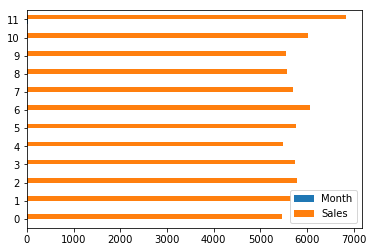

In [27]:
train_store[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales=train_store[['Month','Sales']].groupby('Month',as_index=False).mean().sort_values('Month')
month_sales.plot(kind='barh',rot=0)
plt.show()

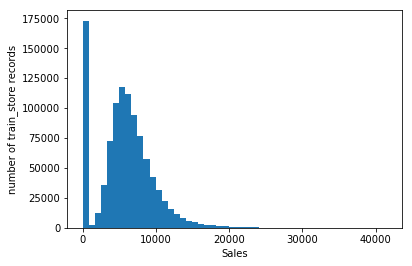

In [28]:
# 平滑sales
plt.hist(train_target.values, bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

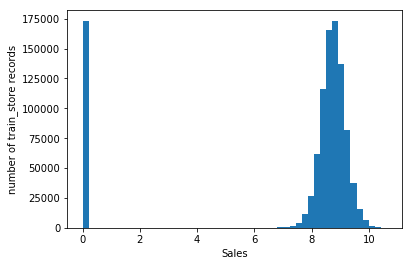

In [29]:
#正态化Sales
train_target=train_store['Sales']
plt.hist(np.log1p(train_target).values, bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

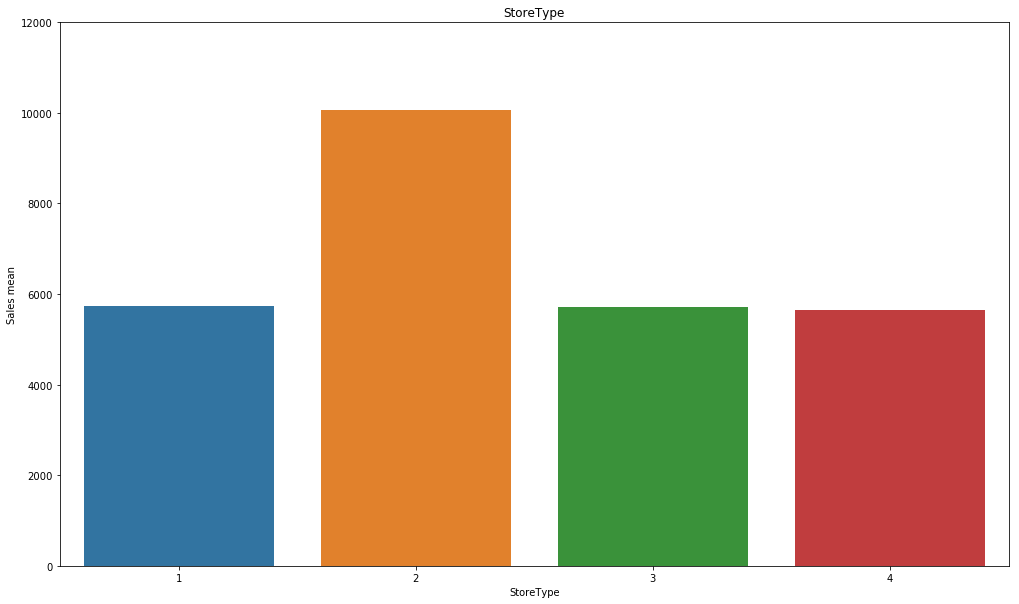

In [30]:
pt = train_store.groupby('StoreType')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=12000)  
plt.title('StoreType')  
plt.ylabel('Sales mean')  
sns.barplot(pt.index,pt.values)
plt.show()

In [31]:
# oneHot处理StoreType
# pdtemp=pd.get_dummies(train_data['StoreType'],prefix='StoreType')
# train_data= pd.concat([train_data,pdtemp], axis=1)
# train_data.drop('StoreType',axis=1, inplace=True)
# train_data.head()

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Assortment,CompetitionDistance,Promo2,Promoing,IsCompetition,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,4,1,1,0,1,2015,7,31,31,1,1270,0,0,1,0,0,1,0
1,3,1,1,0,1,2015,7,30,31,1,1270,0,0,1,0,0,1,0
2,2,1,1,0,1,2015,7,29,31,1,1270,0,0,1,0,0,1,0
3,1,1,1,0,1,2015,7,28,31,1,1270,0,0,1,0,0,1,0
4,0,1,1,0,1,2015,7,27,31,1,1270,0,0,1,0,0,1,0


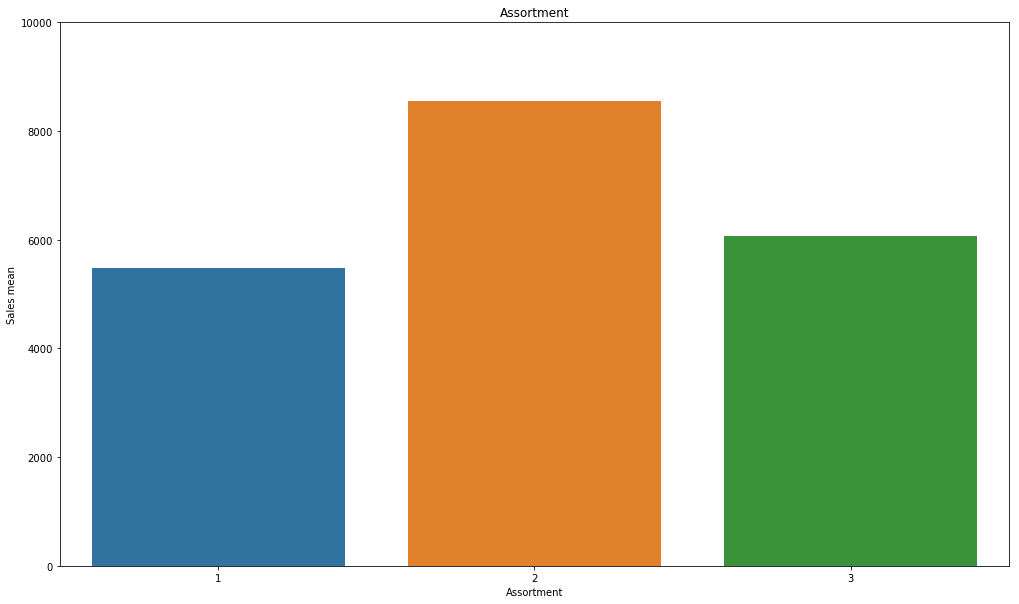

In [32]:
pa = train_store.groupby('Assortment')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=10000)  
plt.title('Assortment')  
plt.ylabel('Sales mean')  
sns.barplot(pa.index,pa.values)
plt.show()

In [33]:
# oneHot处理Assortment
# train_data= pd.concat([train_data,pd.get_dummies(train_data['Assortment'],prefix='Assortment')], axis=1)
# train_data.drop('Assortment',axis=1, inplace=True)
# train_data.head()

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,Promoing,IsCompetition,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
0,4,1,1,0,1,2015,7,31,31,1270,0,0,1,0,0,1,0,1,0,0
1,3,1,1,0,1,2015,7,30,31,1270,0,0,1,0,0,1,0,1,0,0
2,2,1,1,0,1,2015,7,29,31,1270,0,0,1,0,0,1,0,1,0,0
3,1,1,1,0,1,2015,7,28,31,1270,0,0,1,0,0,1,0,1,0,0
4,0,1,1,0,1,2015,7,27,31,1270,0,0,1,0,0,1,0,1,0,0


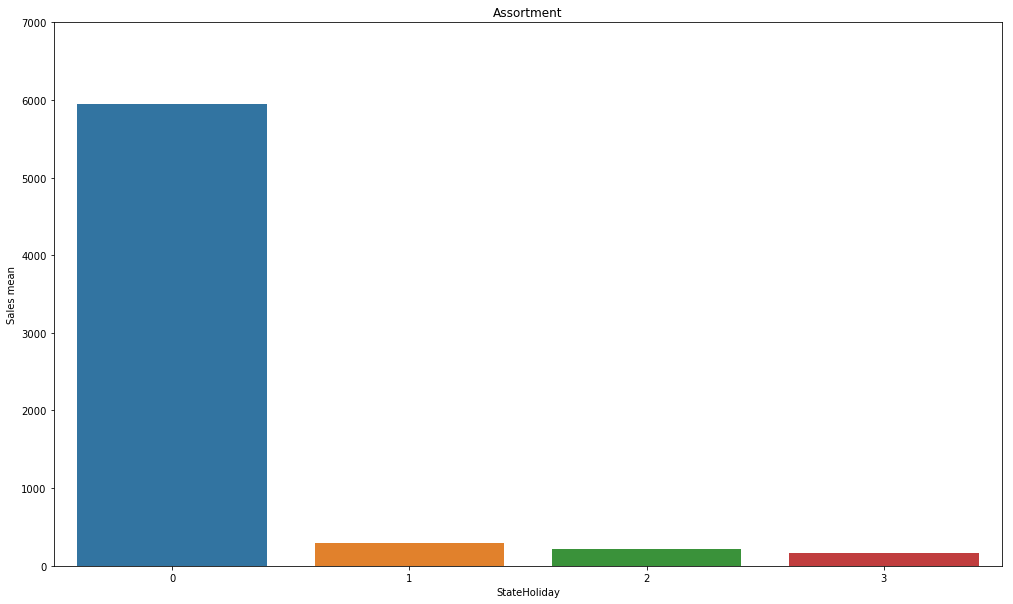

In [34]:
ph = train_store.groupby('StateHoliday')['Sales'].mean()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=7000)  
plt.title('Assortment')  
plt.ylabel('Sales mean')  
sns.barplot(ph.index,ph.values)
plt.show()

In [35]:
# oneHot处理Assortment
# train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
# train_data.drop('StateHoliday',axis=1, inplace=True)
# train_data.head()

,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,...,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,4,1,1,1,2015,7,31,31,1270,0,...,0,1,0,1,0,0,1,0,0,0
1,3,1,1,1,2015,7,30,31,1270,0,...,0,1,0,1,0,0,1,0,0,0
2,2,1,1,1,2015,7,29,31,1270,0,...,0,1,0,1,0,0,1,0,0,0
3,1,1,1,1,2015,7,28,31,1270,0,...,0,1,0,1,0,0,1,0,0,0
4,0,1,1,1,2015,7,27,31,1270,0,...,0,1,0,1,0,0,1,0,0,0


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
DayOfWeek              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
StoreType_1            1017209 non-null uint8
StoreType_2            1017209 non-null uint8
StoreType_3            1017209 non-null uint8
StoreType_4            1017209 non-null uint8
Assortment_1           1017209 non-null uint8
Assortment_2           1017209 non-null uint8
Assortment_3           1017209 non-null uint8
StateHoliday_

In [38]:
x_names = ["DayOfWeek","Open","Promo","SchoolHoliday","Year","Month","Day","WeekOfYear","CompetitionDistance","Promo2","Promoing","IsCompetition","StoreType_1","StoreType_2","StoreType_3","StoreType_4","Assortment_1","Assortment_2","Assortment_3","StateHoliday_0","StateHoliday_1","StateHoliday_2","StateHoliday_3"] 

In [40]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
DayOfWeek              1017209 non-null int64
Open                   1017209 non-null int64
Promo                  1017209 non-null int64
SchoolHoliday          1017209 non-null int64
Year                   1017209 non-null int64
Month                  1017209 non-null int64
Day                    1017209 non-null int64
WeekOfYear             1017209 non-null int64
CompetitionDistance    1017209 non-null int32
Promo2                 1017209 non-null int64
Promoing               1017209 non-null int32
IsCompetition          1017209 non-null int64
StoreType_1            1017209 non-null uint8
StoreType_2            1017209 non-null uint8
StoreType_3            1017209 non-null uint8
StoreType_4            1017209 non-null uint8
Assortment_1           1017209 non-null uint8
Assortment_2           1017209 non-null uint8
Assortment_3           1017209 non-null uint8
StateHoliday_

In [41]:

def plot_feature_scores(x, y, names=None):  
  
    if not names:  
        names = range(len(x[0]))  
  
  
    # 1. 使用 sklearn.feature_selection.SelectKBest 给特征打分  
    slct = SelectKBest(k="all")  
    slct.fit(x, y)  
    scores = slct.scores_  
  
    # 2. 将特征按分数 从大到小 排序  
    named_scores = zip(names, scores)  
    sorted_named_scores = sorted(named_scores, key=lambda z: z[1], reverse=True)  
  
    sorted_scores = [each[1] for each in sorted_named_scores]  
    sorted_names = [each[0] for each in sorted_named_scores]  
  
    y_pos = np.arange(len(names))           # 从上而下的绘图顺序  
  
    # 3. 绘图  
      
    fig, ax =plt.subplots(1,1,figsize=(17,10))  
    ax.barh(y_pos, sorted_scores, height=0.7, align='center', color='#AAAAAA', tick_label=sorted_names)  
    # ax.set_yticklabels(sorted_names)      # 也可以在这里设置 条条 的标签~  
    ax.set_yticks(y_pos)  
    ax.set_xlabel('Feature Score')  
    ax.set_ylabel('Feature Name')  
    ax.invert_yaxis()  
    ax.set_title('F_classif scores of the features.')  
  
    # 4. 添加每个 条条 的数字标签  
    for score, pos in zip(sorted_scores, y_pos):  
        ax.text(score + 20, pos, '%.1f' % score, ha='center', va='bottom', fontsize=12)  
  
    plt.show()  

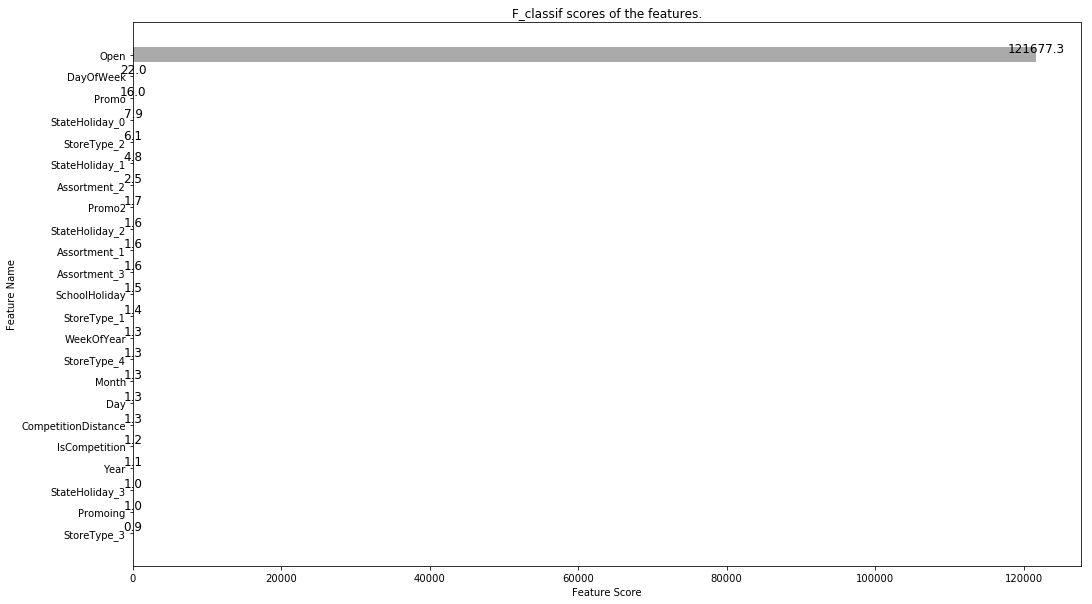

In [42]:
plot_feature_scores(train_data,train_target,x_names)


In [43]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [44]:
# 检查测试数据
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.2, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))


In [47]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

In [48]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:5.28132	eval-rmse:5.28255	train-rmspe:0.908105	eval-rmspe:0.908433
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:3.70402	eval-rmse:3.70475	train-rmspe:0.89409	eval-rmspe:0.894416
[2]	train-rmse:2.60206	eval-rmse:2.60234	train-rmspe:0.854415	eval-rmspe:0.854701
[3]	train-rmse:1.83478	eval-rmse:1.83464	train-rmspe:0.779915	eval-rmspe:0.780021
[4]	train-rmse:1.30221	eval-rmse:1.30175	train-rmspe:0.677057	eval-rmspe:0.676598
[5]	train-rmse:0.935614	eval-rmse:0.934851	train-rmspe:0.563876	eval-rmspe:0.562263
[6]	train-rmse:0.688003	eval-rmse:0.686829	train-rmspe:0.460822	eval-rmspe:0.456874
[7]	train-rmse:0.521199	eval-rmse:0.519624	train-rmspe:0.3805	eval-rmspe:0.373083
[8]	train-rmse:0.41563	eval-rmse:0.413647	train-rmspe:0.327329	eval-rmspe:0.316503
[9]	train-rmse:0.353417	eval-rmse:0.351119	train-rmspe:0.30191	eval-rmspe:0.287285
[10]	train-rmse:0.316509	eval

[96]	train-rmse:0.153982	eval-rmse:0.157917	train-rmspe:0.186973	eval-rmspe:0.161478
[97]	train-rmse:0.153662	eval-rmse:0.157626	train-rmspe:0.186589	eval-rmspe:0.161181
[98]	train-rmse:0.153559	eval-rmse:0.157574	train-rmspe:0.186466	eval-rmspe:0.161085
[99]	train-rmse:0.153296	eval-rmse:0.157334	train-rmspe:0.18622	eval-rmspe:0.16082
[100]	train-rmse:0.153082	eval-rmse:0.157199	train-rmspe:0.185929	eval-rmspe:0.160688
[101]	train-rmse:0.152945	eval-rmse:0.157099	train-rmspe:0.180314	eval-rmspe:0.160598
[102]	train-rmse:0.152851	eval-rmse:0.157084	train-rmspe:0.180221	eval-rmspe:0.160537
[103]	train-rmse:0.152746	eval-rmse:0.157009	train-rmspe:0.180723	eval-rmspe:0.160437
[104]	train-rmse:0.152292	eval-rmse:0.156679	train-rmspe:0.180434	eval-rmspe:0.160167
[105]	train-rmse:0.151815	eval-rmse:0.156331	train-rmspe:0.179923	eval-rmspe:0.159761
[106]	train-rmse:0.151589	eval-rmse:0.156166	train-rmspe:0.179705	eval-rmspe:0.159579
[107]	train-rmse:0.15136	eval-rmse:0.155982	train-rmspe:0.17

[192]	train-rmse:0.131722	eval-rmse:0.144677	train-rmspe:0.153064	eval-rmspe:0.146541
[193]	train-rmse:0.131689	eval-rmse:0.144679	train-rmspe:0.153038	eval-rmspe:0.14653
[194]	train-rmse:0.131506	eval-rmse:0.144741	train-rmspe:0.152899	eval-rmspe:0.146607
[195]	train-rmse:0.131485	eval-rmse:0.144736	train-rmspe:0.152837	eval-rmspe:0.146598
[196]	train-rmse:0.131376	eval-rmse:0.144752	train-rmspe:0.152719	eval-rmspe:0.146584
[197]	train-rmse:0.131255	eval-rmse:0.144757	train-rmspe:0.151906	eval-rmspe:0.146618
[198]	train-rmse:0.131013	eval-rmse:0.144639	train-rmspe:0.151747	eval-rmspe:0.146494
[199]	train-rmse:0.130844	eval-rmse:0.144523	train-rmspe:0.151589	eval-rmspe:0.146425
[200]	train-rmse:0.13059	eval-rmse:0.144405	train-rmspe:0.151414	eval-rmspe:0.146274
[201]	train-rmse:0.130553	eval-rmse:0.144389	train-rmspe:0.151351	eval-rmspe:0.146224
[202]	train-rmse:0.130418	eval-rmse:0.144337	train-rmspe:0.151246	eval-rmspe:0.146155
[203]	train-rmse:0.130397	eval-rmse:0.144326	train-rmspe

[288]	train-rmse:0.122742	eval-rmse:0.143544	train-rmspe:0.142884	eval-rmspe:0.144841
[289]	train-rmse:0.122731	eval-rmse:0.143548	train-rmspe:0.142867	eval-rmspe:0.14483
[290]	train-rmse:0.122721	eval-rmse:0.143545	train-rmspe:0.14285	eval-rmspe:0.144836
[291]	train-rmse:0.122559	eval-rmse:0.14345	train-rmspe:0.142673	eval-rmspe:0.144737
[292]	train-rmse:0.122551	eval-rmse:0.143445	train-rmspe:0.142663	eval-rmspe:0.144729
[293]	train-rmse:0.122541	eval-rmse:0.143453	train-rmspe:0.142678	eval-rmspe:0.144788
[294]	train-rmse:0.122474	eval-rmse:0.143427	train-rmspe:0.142583	eval-rmspe:0.144729
[295]	train-rmse:0.122389	eval-rmse:0.143374	train-rmspe:0.142357	eval-rmspe:0.144551
[296]	train-rmse:0.122315	eval-rmse:0.143325	train-rmspe:0.142353	eval-rmspe:0.144577
[297]	train-rmse:0.122308	eval-rmse:0.143326	train-rmspe:0.142395	eval-rmspe:0.144585
[298]	train-rmse:0.122304	eval-rmse:0.143326	train-rmspe:0.142404	eval-rmspe:0.144577
[299]	train-rmse:0.122255	eval-rmse:0.143322	train-rmspe:

In [49]:
# 验证结果
train_probs = gbm.predict(xgb.DMatrix(X_test))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.expm1(train_probs),y_test.values)
print('error', error)


error 0.144600819972


In [51]:
# 根据train_data来处理test_data
# test_data= pd.concat([test_data,pd.get_dummies(test_data['StoreType'],prefix='StoreType')], axis=1)
# test_data.drop('StoreType',axis=1, inplace=True)
# test_data= pd.concat([test_data,pd.get_dummies(test_data['Assortment'],prefix='Assortment')], axis=1)
# test_data.drop('Assortment',axis=1, inplace=True)
# test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
# test_data.drop('StateHoliday',axis=1, inplace=True)
test_data.head()

,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,...,IsCompetition,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,StateHoliday_0,StateHoliday_1
0,3,1,1,0,2015,9,17,38,1270,0,...,1,0,0,1,0,1,0,0,1,0
1,2,1,1,0,2015,9,16,38,1270,0,...,1,0,0,1,0,1,0,0,1,0
2,1,1,1,0,2015,9,15,38,1270,0,...,1,0,0,1,0,1,0,0,1,0
3,0,1,1,0,2015,9,14,38,1270,0,...,1,0,0,1,0,1,0,0,1,0
4,6,0,0,0,2015,9,13,37,1270,0,...,1,0,0,1,0,1,0,0,1,0


In [54]:
# 结论输出
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0
dtest = xgb.DMatrix(test_data)
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)